<a href="https://colab.research.google.com/github/utkarsh0702/Projects/blob/master/Missing_Value_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [ ]:
result = pd.read_csv('new_train.csv', parse_dates=['Date'])
result['Date'] = pd.to_datetime(result['Date'], errors='coerce')
result

,Date,Open-Stock-1,High-Stock-1,Low-Stock-1,Close-Stock-1,VWAP-Stock-1,Volume-Stock-1,Turnover-Stock-1,Open-Stock-2,High-Stock-2,Low-Stock-2,Close-Stock-2,VWAP-Stock-2,Volume-Stock-2,Turnover-Stock-2,Open-Stock-3,High-Stock-3,Low-Stock-3,Close-Stock-3,VWAP-Stock-3,Volume-Stock-3,Turnover-Stock-3,Open-Stock-4,High-Stock-4,Low-Stock-4,Close-Stock-4,VWAP-Stock-4,Volume-Stock-4,Turnover-Stock-4,Open-Stock-5,High-Stock-5,Low-Stock-5,Close-Stock-5,VWAP-Stock-5,Volume-Stock-5,Turnover-Stock-5
0,2010-06-01,1889.70,1890.00,1838.00,1855.10,1855.75,568273,105457457545000,285.40,285.95,281.50,283.00,283.72,3191773,90557243170000,2095.00,2097.80,2045.00,2077.25,2088.95,70547,14736933230000,851.65,864.80,833.10,837.95,844.44,3878011,327474904340000,1235.0,1238.00,1177.00,1181.70,1197.29,1786082,213845404410000
1,2010-06-02,1848.00,1862.75,1828.00,1853.05,1842.82,945167,174177161135000,284.00,284.80,279.25,281.30,281.05,2704797,76017076445000,2061.45,2098.00,2023.00,2079.85,2059.52,55547,11440017990000,844.70,849.90,823.00,842.30,838.31,3320996,278403743240000,1195.0,1206.95,1168.50,1201.15,1189.87,1307410,155564994855000
2,2010-06-03,1864.10,1910.00,1864.10,1905.60,1893.91,679689,128727119355000,283.00,286.85,282.50,285.50,285.34,2489752,71043460510000,2131.50,2131.50,2091.05,2114.90,2107.84,55130,11620529360000,851.40,859.05,848.20,854.10,853.51,2494522,212910342645000,1211.0,1248.00,1211.00,1242.30,1231.63,1482919,182640434320000
3,2010-06-04,1906.00,1909.80,1880.10,1885.70,1889.21,509435,96242800140000,288.85,291.80,277.00,290.85,289.81,3188813,92414802585000,2114.90,2156.00,2095.50,2146.75,2145.36,29302,6286330280000,854.10,868.60,854.10,865.85,862.85,2963920,255740999120000,1240.0,1258.00,1240.00,1245.45,1249.72,1454459,181767075850000
4,2010-06-07,1867.00,1894.85,1808.35,1876.65,1873.32,961913,180196832650000,285.00,289.10,285.00,287.70,287.01,2198836,63109395135000,2132.35,2209.00,2112.00,2185.25,2180.52,78919,17208425860000,712.00,850.00,712.00,841.95,839.89,3471483,291567400640000,1218.6,1225.00,1196.00,1214.80,1209.27,1424594,172272511430000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,2011-07-28,499.50,499.50,484.60,487.30,489.79,5354489,262255417380000,198.35,207.00,198.35,206.25,204.68,16270594,333026806690000,3105.85,3143.00,3105.85,3120.85,3121.98,155200,48453078985000,1012.10,1035.50,1010.00,1017.45,1021.77,3823471,390670692820000,1285.0,1307.95,1285.00,1301.50,1297.00,1353005,175484999030000
295,2011-07-29,489.90,489.90,481.10,486.80,485.65,2997667,145582296035000,205.50,211.25,205.25,208.35,208.89,13288551,277587677435000,3122.40,3140.05,3115.00,3134.00,3129.24,28578,8942753035000,1011.00,1051.00,1003.60,1036.75,1032.52,6537105,674969821765000,1300.0,1342.00,1292.40,1337.50,1325.46,1850972,245338665665000
296,2011-08-01,493.45,495.95,484.50,488.00,489.14,2202354,107726909450000,210.00,211.25,208.10,208.90,209.13,7104094,148570564060000,3141.95,3163.00,3053.50,3067.85,3100.07,36332,11263166685000,1052.80,1059.70,1038.70,1045.35,1049.87,2088359,219249912200000,1349.0,1367.55,1346.50,1353.00,1357.02,1226610,166453494180000
297,2011-08-02,487.90,487.90,480.00,482.85,483.30,1982494,95814144795000,207.70,208.35,202.85,204.75,205.13,7645467,156835059215000,3067.85,3069.00,3001.10,3052.15,3047.39,177189,53996461955000,1039.90,1041.35,1018.10,1021.70,1025.73,2925557,300083555650000,1345.0,1347.95,1326.10,1342.80,1334.07,970086,129416608470000


In [ ]:
test = pd.read_csv('new_test.csv', parse_dates=['Date'])
test['Date'] = pd.to_datetime(test['Date'], errors='coerce')
test

,Date,Open-Stock-1,High-Stock-1,Low-Stock-1,VWAP-Stock-1,Volume-Stock-1,Turnover-Stock-1,Open-Stock-2,High-Stock-2,Low-Stock-2,VWAP-Stock-2,Volume-Stock-2,Turnover-Stock-2,Open-Stock-3,High-Stock-3,Low-Stock-3,VWAP-Stock-3,Volume-Stock-3,Turnover-Stock-3,Open-Stock-4,High-Stock-4,Low-Stock-4,VWAP-Stock-4,Volume-Stock-4,Turnover-Stock-4,Open-Stock-5,High-Stock-5,Low-Stock-5,VWAP-Stock-5,Volume-Stock-5,Turnover-Stock-5
0,2011-08-04,484.1,488.90,475.00,481.00,1829606,88003633160000,204.90,206.75,199.20,202.98,10501999,213174133870000,3011.15,3119.95,3011.15,3078.97,53783,16559616060000,1008.50,1015.0,990.00,1003.31,2716435,272542181190000,1303.60,1312.8,1281.00,1297.04,1569675,203593328285000
1,2011-08-05,465.0,475.80,457.10,469.56,3156094,148196817355000,195.00,198.00,190.50,194.86,13424736,261588793565000,3091.65,3095.00,3012.00,3061.60,129372,39608524605000,970.00,979.7,950.00,961.50,4644498,446567961345000,1245.00,1252.5,1200.00,1229.09,3125692,384176649890000
2,2011-08-08,463.0,480.00,458.05,465.04,4308373,200357861965000,193.90,197.80,189.65,194.89,9002509,175445729750000,3015.05,3109.00,3010.00,3069.09,46725,14340318455000,940.05,975.0,933.40,953.24,3450619,328925252905000,1205.20,1265.8,1200.55,1232.93,1660178,204687918340000
3,2011-08-09,450.0,473.55,449.85,460.88,4490924,206978212685000,190.25,202.10,190.10,197.61,19202643,379464261110000,3070.00,3164.00,2988.00,3113.84,88749,27635029505000,915.00,967.6,910.45,938.80,5346085,501890604795000,1190.50,1238.3,1180.90,1206.06,3618186,436376441205000
4,2011-08-10,494.8,494.80,473.40,478.06,3267226,156192368225000,202.00,202.85,196.00,199.07,9274996,184640866420000,3125.00,3195.00,3125.00,3170.39,52720,16714302965000,963.95,971.2,957.70,964.75,3379659,326053305165000,1242.00,1253.7,1225.30,1242.10,1903396,236421421150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,2011-12-22,431.5,444.80,428.80,436.74,3394017,148230026405000,200.90,204.00,200.50,203.30,6294512,127965452355000,2720.00,2775.00,2652.00,2713.39,24071,6531398525000,690.00,741.0,683.60,708.17,8809539,623863856910000,842.25,878.3,840.40,862.30,3090876,266526167930000
93,2011-12-23,444.2,446.50,436.00,441.43,1713825,75653641865000,204.40,205.00,202.25,203.68,5517744,112387434385000,2760.25,2769.20,2640.95,2693.93,54094,14572535770000,728.40,734.4,714.30,724.00,5543359,401337831485000,885.00,896.0,865.65,881.28,2932357,258423344725000
94,2011-12-26,439.0,445.40,437.05,442.87,1141190,50539686080000,203.40,205.85,202.80,204.96,3847514,78858145570000,2647.15,2695.00,2641.05,2665.46,28086,7486220875000,721.00,734.7,719.05,729.09,2573228,187610694795000,880.00,891.0,867.00,877.12,1706610,149689505180000
95,2011-12-27,440.3,443.60,435.70,439.39,1573559,69140882195000,204.90,206.00,202.30,204.65,4659202,95349316255000,2655.05,2692.00,2655.05,2671.18,77746,20767317225000,727.10,734.0,721.35,726.56,3280754,238367227070000,872.40,872.8,839.80,853.02,1742237,148616550585000


# Stock 1

In [ ]:
df1= result.loc[:,['Date','Close-Stock-1']]
df1.head()

,Date,Close-Stock-1
0,2010-06-01,1855.10
1,2010-06-02,1853.05
2,2010-06-03,1905.60
3,2010-06-04,1885.70
4,2010-06-07,1876.65


In [ ]:
idx = pd.date_range(df1.Date.min(), df1.Date.max())
df1.set_index('Date', inplace=True)

**Cubic Spline interpolation**

In [ ]:
df1 = df1.reindex(idx)
df1.index.name = 'Date'
# df1= df1.replace({0:np.NaN})
df1= df1.interpolate(method='spline', order=3, s=0.)
df1 = df1.round(2)
df1

,Close-Stock-1
Date,
2010-06-01,1855.10
2010-06-02,1853.05
2010-06-03,1905.60
2010-06-04,1885.70
2010-06-05,1873.50
...,...
2011-07-30,490.04
2011-07-31,490.67
2011-08-01,488.00


In [ ]:
array = df1.to_numpy().reshape(-1,1)
array.shape

(429, 1)

In [ ]:
#taking mean and standered deviation
array_mean = array.mean()
array_std = array.std()
#normalizing the data
array = (array-array_mean)/array_std

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [ ]:
univariate_past_history = 12
univariate_future_target = 0

x, y = univariate_data(array, 0, None, univariate_past_history, univariate_future_target)

In [ ]:
print('X Shape:',x.shape)
print('Y Shape:',y.shape)

X Shape: (417, 12, 1)
Y Shape: (417, 1)


**Learning Rate Scheduling**

In [ ]:
tf.keras.backend.clear_session()

#creating model
model= tf.keras.models.Sequential([
                                  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, activation='relu', dropout=0.25, recurrent_dropout=0.2, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, activation='relu', dropout=0.25, recurrent_dropout=0.3, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12, activation='relu', return_sequences=True, activity_regularizer=keras.regularizers.l2())), 
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6, activation='relu', return_sequences=True,  activity_regularizer=keras.regularizers.l2())), 
                                   tf.keras.layers.LSTM(6, activation='relu'), 
                                   tf.keras.layers.Dropout(0.4),  
                                   tf.keras.layers.Dense(1)
                                   ])
lr_schedular= tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-6*10**(x/20))

adam= tf.keras.optimizers.Adam(lr=1e-6)
model.compile(optimizer= adam, loss= 'mse')
#Smodel.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 96)          19200     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 48)          23232     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 24)          5856      
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 12)          1488      
_________________________________________________________________
lstm_4 (LSTM)                (None, 6)                 456       
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0

In [ ]:
history= model.fit(x, y, epochs= 125, callbacks= [lr_schedular], verbose=0)

In [ ]:
loss= min(history.history['loss'])
losses= history.history['loss']
index=losses.index(loss)
lrs= history.history['lr']
count=0
for i in lrs:
  if count==index:
    lr=i
    break
  count+=1
print(lr)
print(loss)

0.014125375
0.22692227363586426


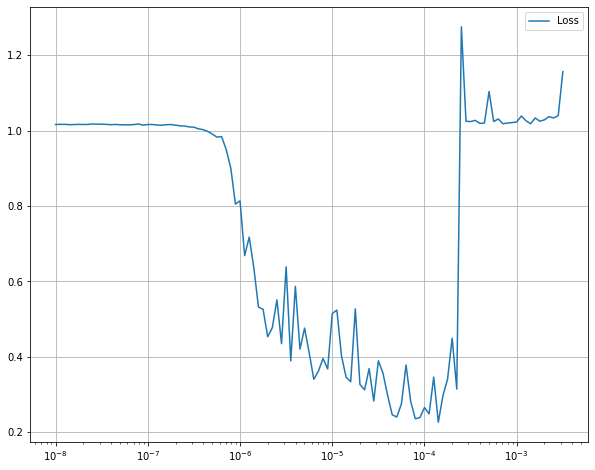

In [ ]:
lrs= 1e-8*(10**(np.arange(125)/20))
plt.semilogx(lrs, history.history["loss"], label='Loss')
plt.legend(loc='best')
plt.grid(True)

**Model Training**

In [ ]:
tf.keras.backend.clear_session()

#creating model
model= tf.keras.models.Sequential([
                                  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, activation='relu', dropout=0.25, recurrent_dropout=0.2, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, activation='relu', dropout=0.25, recurrent_dropout=0.3, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12, activation='relu', return_sequences=True, activity_regularizer=keras.regularizers.l2())), 
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6, activation='relu', return_sequences=True,  activity_regularizer=keras.regularizers.l2())), 
                                   tf.keras.layers.LSTM(6, activation='relu'), 
                                   tf.keras.layers.Dropout(0.4),  
                                   tf.keras.layers.Dense(1)
                                   ])

adam= tf.keras.optimizers.Adam(lr=lr)
model.compile(optimizer= adam, loss= 'mse')
#Smodel.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 24)          1344      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 12)          1488      
_________________________________________________________________
lstm_2 (LSTM)                (None, 6)                 456       
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 3,295
Trainable params: 3,295
Non-trainable params: 0
______________________________________________________

In [ ]:
history= model.fit(x,y, epochs= 300, verbose=0)

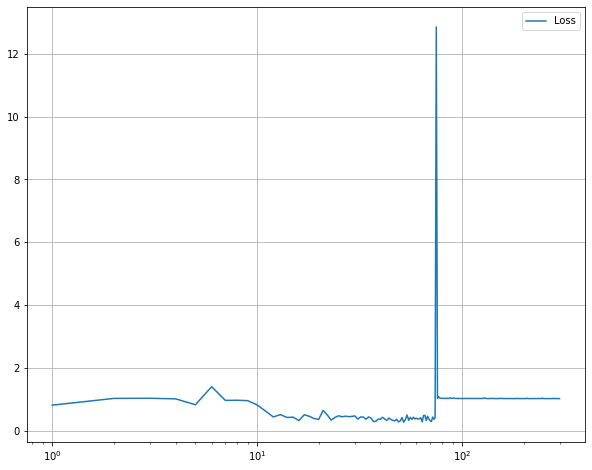

In [ ]:
epochs= range(1,301)
plt.semilogx(epochs, history.history["loss"], label='Loss')
plt.legend(loc='best')
plt.grid(True)

(417, 12, 1)
(417, 1)


[]

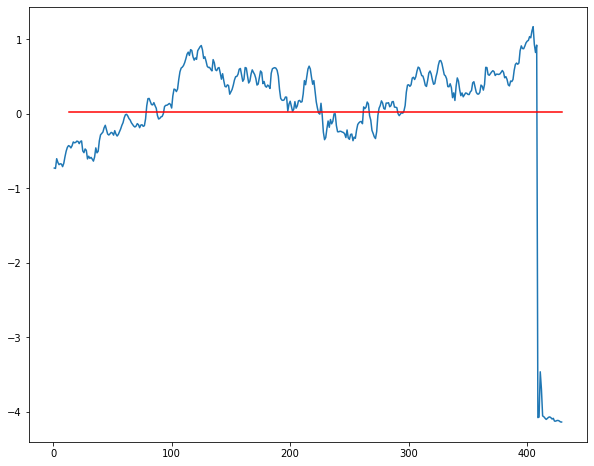

In [ ]:
numbers=range(1, 430)
num= range(13,430)
plt.figure()
print(x.shape)
y_pred= model.predict(x)
print(y_pred.shape)
plt.plot(numbers,array)
plt.plot(num,y_pred,'r')
plt.plot()

**Test Phase**

[]

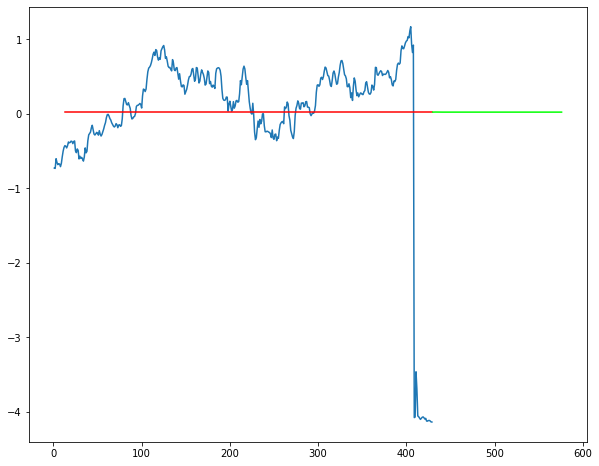

In [ ]:
numbers=range(1, 430)
num= range(13,430)
pred= range(430,577)
plot_pred=[]
real_val=[]
plt.figure()
y_pred= model.predict(x)
plt.plot(numbers,array)
plt.plot(num,y_pred,'r')
x_new= array[416: len(array)-1]
for i in range(147):
  x_new= x_new.reshape(1,12,1)
  y_new= model.predict(x_new)
  x_new= x_new[0][1:]
  x_new= np.append(x_new, y_new)
  y_new= y_new.reshape(1,)
  real= y_new*array_std+array_mean
  plot_pred.append(y_new)
  real_val.append(real)

plt.plot(pred, plot_pred, color='#00ff00')
plt.plot()

In [ ]:
pred_array = np.array(real_val)
pred_array.shape

(147, 1)

In [ ]:
rng = pd.date_range('2011-08-04', '2011-12-28')
answer = pd.DataFrame({ 'Date': rng, 'Close-Stock-1': pred_array.flatten()})
answer

,Date,Close-Stock-1
0,2011-08-04,574.658691
1,2011-08-05,574.593018
2,2011-08-06,574.630981
3,2011-08-07,574.512451
4,2011-08-08,574.598389
...,...,...
142,2011-12-24,574.191040
143,2011-12-25,574.190918
144,2011-12-26,574.191040
145,2011-12-27,574.190918


# Stock 2

In [ ]:
df2= result.loc[:,['Date','Close-Stock-2']]
df2.head()

,Date,Close-Stock-2
0,2010-06-01,283.00
1,2010-06-02,281.30
2,2010-06-03,285.50
3,2010-06-04,290.85
4,2010-06-07,287.70


In [ ]:
idx = pd.date_range(df2.Date.min(), df2.Date.max())
df2.set_index('Date', inplace=True)

**Cubic Spline interpolation**

In [ ]:
df2 = df2.reindex(idx)
df2.index.name = 'Date'
# df1= df1.replace({0:np.NaN})
df2= df2.interpolate(method='spline', order=3, s=0.)
df2 = df2.round(2)
df2

,Close-Stock-2
Date,
2010-06-01,283.00
2010-06-02,281.30
2010-06-03,285.50
2010-06-04,290.85
2010-06-05,290.40
...,...
2011-07-30,209.88
2011-07-31,210.69
2011-08-01,208.90


In [ ]:
array = df2.to_numpy().reshape(-1,1)
array.shape

(429, 1)

In [ ]:
#taking mean and standered deviation
array_mean = array.mean()
array_std = array.std()
#normalizing the data
array = (array-array_mean)/array_std

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [ ]:
univariate_past_history = 12
univariate_future_target = 0

x, y = univariate_data(array, 0, None, univariate_past_history, univariate_future_target)

In [ ]:
print('X Shape:',x.shape)
print('Y Shape:',y.shape)

X Shape: (417, 12, 1)
Y Shape: (417, 1)


**Learning Rate Scheduling**

In [ ]:
tf.keras.backend.clear_session()

#creating model
model= tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, activation='relu', dropout=0.25, recurrent_dropout=0.2, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.3, return_sequences=True)), 
                                   tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.1), 
                                   tf.keras.layers.Dropout(0.15),  
                                   tf.keras.layers.Dense(1)
                                   ])
lr_schedular= tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-6*10**(x/20))

adam= tf.keras.optimizers.Adam(lr=1e-6)
model.compile(optimizer= adam, loss= 'mse')
#Smodel.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 48)          4992      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 24)          5856      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 12,637
Trainable params: 12,637
Non-trainable params: 0
____________________________________________________

In [ ]:
history= model.fit(x, y, epochs= 125, callbacks= [lr_schedular], verbose=0)

In [ ]:
loss= min(history.history['loss'])
losses= history.history['loss']
index=losses.index(loss)
lrs= history.history['lr']
count=0
for i in lrs:
  if count==index:
    lr=i
    break
  count+=1
print(lr)
print(loss)

0.0063095735
0.0833323672413826


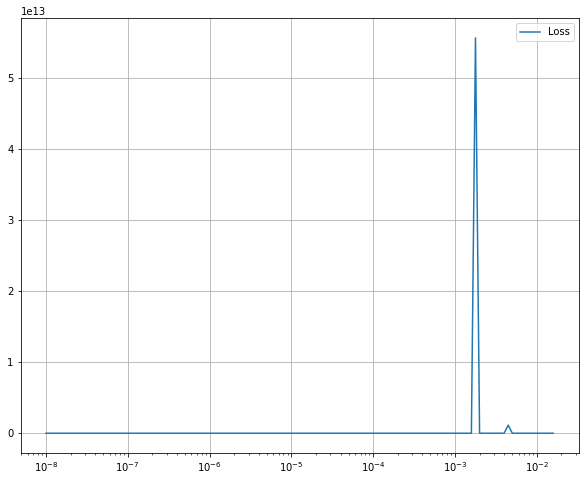

In [ ]:
lrs= 1e-8*(10**(np.arange(125)/20))
plt.semilogx(lrs, history.history["loss"], label='Loss')
plt.legend(loc='best')
plt.grid(True)

**Model Training**

In [ ]:
tf.keras.backend.clear_session()

#creating model
model= tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, activation='relu', dropout=0.25, recurrent_dropout=0.2, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.3, return_sequences=True)), 
                                   tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.1), 
                                   tf.keras.layers.Dropout(0.15),  
                                   tf.keras.layers.Dense(1)
                                   ])

adam= tf.keras.optimizers.Adam(lr=lr)
model.compile(optimizer= adam, loss= 'mse')
#Smodel.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 48)          4992      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 24)          5856      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 12,637
Trainable params: 12,637
Non-trainable params: 0
____________________________________________________

In [ ]:
history= model.fit(x,y, epochs= 300, verbose=0)

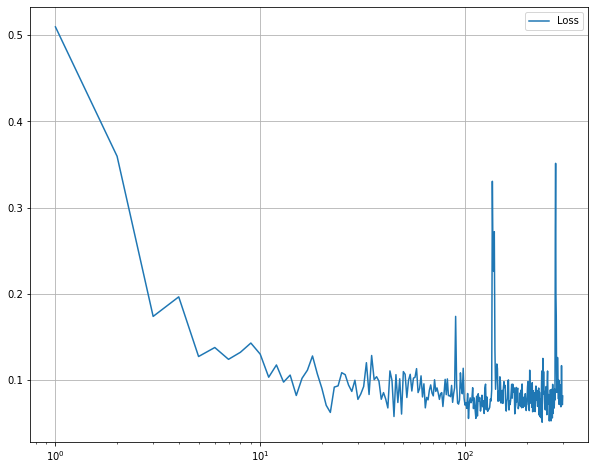

In [ ]:
epochs= range(1,301)
plt.semilogx(epochs, history.history["loss"], label='Loss')
plt.legend(loc='best')
plt.grid(True)

(417, 12, 1)
(417, 1)


[]

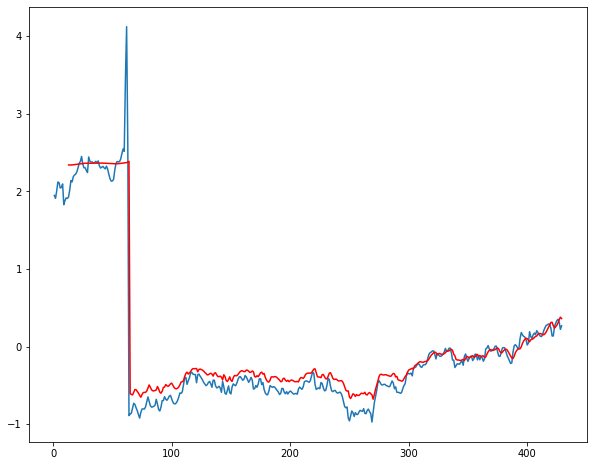

In [ ]:
numbers=range(1, 430)
num= range(13,430)
plt.figure()
print(x.shape)
y_pred= model.predict(x)
print(y_pred.shape)
plt.plot(numbers,array)
plt.plot(num,y_pred,'r')
plt.plot()

**Test Phase**

[]

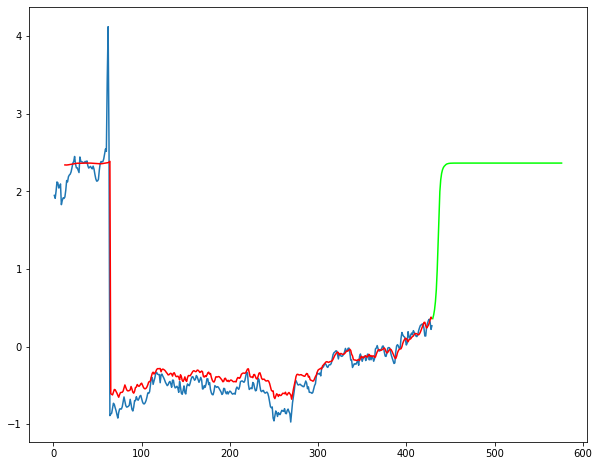

In [ ]:
numbers=range(1, 430)
num= range(13,430)
pred= range(430,577)
plot_pred=[]
real_val=[]
plt.figure()
y_pred= model.predict(x)
plt.plot(numbers,array)
plt.plot(num,y_pred,'r')
x_new= array[416: len(array)-1]
for i in range(147):
  x_new= x_new.reshape(1,12,1)
  y_new= model.predict(x_new)
  x_new= x_new[0][1:]
  x_new= np.append(x_new, y_new)
  y_new= y_new.reshape(1,)
  real= y_new*array_std+array_mean
  plot_pred.append(y_new)
  real_val.append(real)

plt.plot(pred, plot_pred, color='#00ff00')
plt.plot()

In [ ]:
pred_array = np.array(real_val)
pred_array.shape

(147, 1)

In [ ]:
answer['Close-Stock-2'] = pred_array.flatten()
answer

,Date,Close-Stock-1,Close-Stock-2
0,2011-08-04,574.658691,211.067871
1,2011-08-05,574.593018,213.217712
2,2011-08-06,574.630981,216.291580
3,2011-08-07,574.512451,220.956924
4,2011-08-08,574.598389,227.928192
...,...,...,...
142,2011-12-24,574.191040,301.884796
143,2011-12-25,574.190918,301.884796
144,2011-12-26,574.191040,301.884796
145,2011-12-27,574.190918,301.884796


# Stock 3

In [ ]:
df3= result.loc[:,['Date','Close-Stock-3']]
df3.head()

,Date,Close-Stock-3
0,2010-06-01,2077.25
1,2010-06-02,2079.85
2,2010-06-03,2114.90
3,2010-06-04,2146.75
4,2010-06-07,2185.25


In [ ]:
idx = pd.date_range(df3.Date.min(), df3.Date.max())
df3.set_index('Date', inplace=True)

**Cubic Spline interpolation**

In [ ]:
df3 = df3.reindex(idx)
df3.index.name = 'Date'
# df1= df1.replace({0:np.NaN})
df3= df3.interpolate(method='spline', order=3, s=0.)
df3 = df3.round(2)
df3

,Close-Stock-3
Date,
2010-06-01,2077.25
2010-06-02,2079.85
2010-06-03,2114.90
2010-06-04,2146.75
2010-06-05,2156.78
...,...
2011-07-30,3126.50
2011-07-31,3096.90
2011-08-01,3067.85


In [ ]:
array = df3.to_numpy().reshape(-1,1)
array.shape

(429, 1)

In [ ]:
#taking mean and standered deviation
array_mean = array.mean()
array_std = array.std()
#normalizing the data
array = (array-array_mean)/array_std

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [ ]:
univariate_past_history = 12
univariate_future_target = 0

x, y = univariate_data(array, 0, None, univariate_past_history, univariate_future_target)

In [ ]:
print('X Shape:',x.shape)
print('Y Shape:',y.shape)

X Shape: (417, 12, 1)
Y Shape: (417, 1)


**Learning Rate Scheduling**

In [ ]:
tf.keras.backend.clear_session()

#creating model
model= tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, activation='relu', dropout=0.25, recurrent_dropout=0.2, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, activation='relu', dropout=0.25, recurrent_dropout=0.3, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12, activation='relu', return_sequences=True, activity_regularizer=keras.regularizers.l2())), 
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6, activation='relu', return_sequences=True,  activity_regularizer=keras.regularizers.l2())), 
                                   tf.keras.layers.LSTM(6, activation='relu'), 
                                   tf.keras.layers.Dropout(0.4),  
                                   tf.keras.layers.Dense(1)
                                   ])
lr_schedular= tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-6*10**(x/20))

adam= tf.keras.optimizers.Adam(lr=1e-6)
model.compile(optimizer= adam, loss= 'mse')
#Smodel.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 48)          4992      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 24)          5856      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 12,637
Trainable params: 12,637
Non-trainable params: 0
____________________________________________________

In [ ]:
history= model.fit(x, y, epochs= 125, callbacks= [lr_schedular], verbose=0)

In [ ]:
loss= min(history.history['loss'])
losses= history.history['loss']
index=losses.index(loss)
lrs= history.history['lr']
count=0
for i in lrs:
  if count==index:
    lr=i
    break
  count+=1
print(lr)
print(loss)

0.0039810715
0.11471155285835266


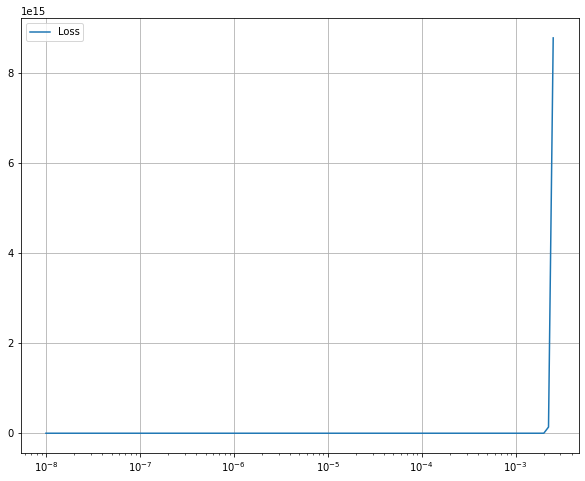

In [ ]:
lrs= 1e-8*(10**(np.arange(125)/20))
plt.semilogx(lrs, history.history["loss"], label='Loss')
plt.legend(loc='best')
plt.grid(True)

**Model Training**

In [ ]:
tf.keras.backend.clear_session()

#creating model
model= tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, activation='relu', dropout=0.25, recurrent_dropout=0.2, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, activation='relu', dropout=0.25, recurrent_dropout=0.3, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12, activation='relu', return_sequences=True, activity_regularizer=keras.regularizers.l2())), 
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6, activation='relu', return_sequences=True,  activity_regularizer=keras.regularizers.l2())), 
                                   tf.keras.layers.LSTM(6, activation='relu'), 
                                   tf.keras.layers.Dropout(0.4),  
                                   tf.keras.layers.Dense(1)
                                   ])

adam= tf.keras.optimizers.Adam(lr=lr)
model.compile(optimizer= adam, loss= 'mse')
#Smodel.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 48)          4992      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 24)          5856      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 12,637
Trainable params: 12,637
Non-trainable params: 0
____________________________________________________

In [ ]:
history= model.fit(x,y, epochs= 300, verbose=0)

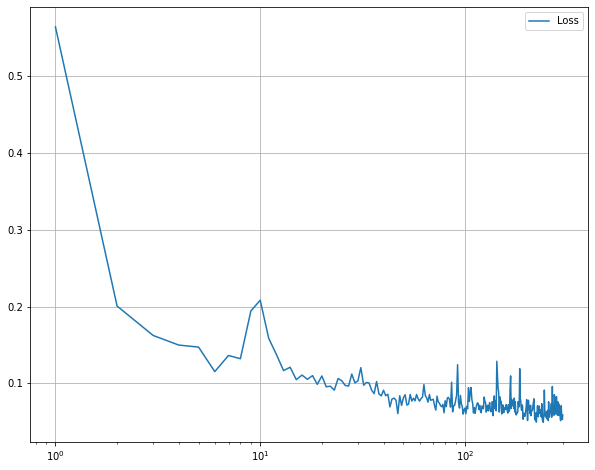

In [ ]:
epochs= range(1,301)
plt.semilogx(epochs, history.history["loss"], label='Loss')
plt.legend(loc='best')
plt.grid(True)

(417, 12, 1)
(417, 1)


[]

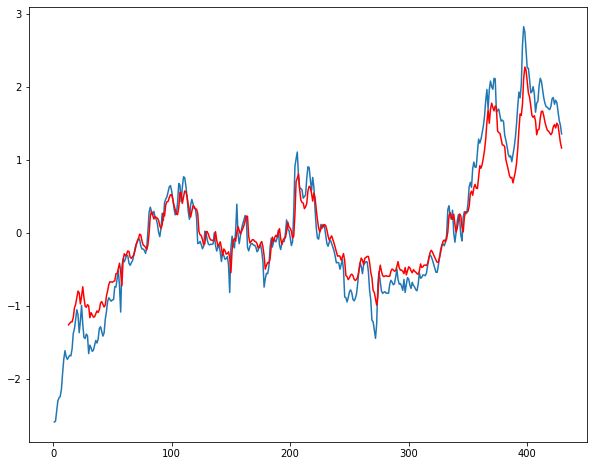

In [ ]:
numbers=range(1, 430)
num= range(13,430)
plt.figure()
print(x.shape)
y_pred= model.predict(x)
print(y_pred.shape)
plt.plot(numbers,array)
plt.plot(num,y_pred,'r')
plt.plot()

**Test Phase**

[]

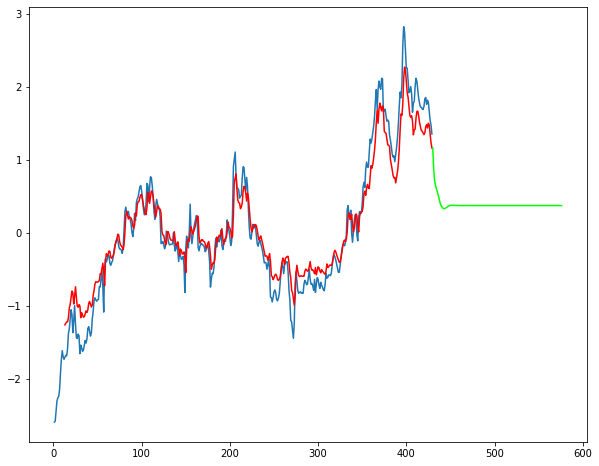

In [ ]:
numbers=range(1, 430)
num= range(13,430)
pred= range(430,577)
plot_pred=[]
real_val=[]
plt.figure()
y_pred= model.predict(x)
plt.plot(numbers,array)
plt.plot(num,y_pred,'r')
x_new= array[416: len(array)-1]
for i in range(147):
  x_new= x_new.reshape(1,12,1)
  y_new= model.predict(x_new)
  x_new= x_new[0][1:]
  x_new= np.append(x_new, y_new)
  y_new= y_new.reshape(1,)
  real= y_new*array_std+array_mean
  plot_pred.append(y_new)
  real_val.append(real)

plt.plot(pred, plot_pred, color='#00ff00')
plt.plot()

In [ ]:
pred_array = np.array(real_val)
pred_array.shape

(147, 1)

In [ ]:
answer['Close-Stock-3'] = pred_array.flatten()
answer

,Date,Close-Stock-1,Close-Stock-2,Close-Stock-3
0,2011-08-04,574.658691,211.067871,2977.268799
1,2011-08-05,574.593018,213.217712,2910.111572
2,2011-08-06,574.630981,216.291580,2871.305176
3,2011-08-07,574.512451,220.956924,2855.853760
4,2011-08-08,574.598389,227.928192,2844.355469
...,...,...,...,...
142,2011-12-24,574.191040,301.884796,2788.281006
143,2011-12-25,574.190918,301.884796,2788.281006
144,2011-12-26,574.191040,301.884796,2788.281006
145,2011-12-27,574.190918,301.884796,2788.281006


# Stock 4

In [ ]:
df4= result.loc[:,['Date','Close-Stock-4']]
df4.head()

,Date,Close-Stock-4
0,2010-06-01,837.95
1,2010-06-02,842.30
2,2010-06-03,854.10
3,2010-06-04,865.85
4,2010-06-07,841.95


In [ ]:
idx = pd.date_range(df4.Date.min(), df4.Date.max())
df4.set_index('Date', inplace=True)

**Cubic Spline interpolation**

In [ ]:
df4 = df4.reindex(idx)
df4.index.name = 'Date'
# df1= df1.replace({0:np.NaN})
df4= df4.interpolate(method='spline', order=3, s=0.)
df4 = df4.round(2)
df4

,Close-Stock-4
Date,
2010-06-01,837.95
2010-06-02,842.30
2010-06-03,854.10
2010-06-04,865.85
2010-06-05,869.97
...,...
2011-07-30,1053.39
2011-07-31,1056.67
2011-08-01,1045.35


In [ ]:
array = df4.to_numpy().reshape(-1,1)
array.shape

(429, 1)

In [ ]:
#taking mean and standered deviation
array_mean = array.mean()
array_std = array.std()
#normalizing the data
array = (array-array_mean)/array_std

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [ ]:
univariate_past_history = 12
univariate_future_target = 0

x, y = univariate_data(array, 0, None, univariate_past_history, univariate_future_target)

In [ ]:
print('X Shape:',x.shape)
print('Y Shape:',y.shape)

X Shape: (417, 12, 1)
Y Shape: (417, 1)


**Learning Rate Scheduling**

In [ ]:
tf.keras.backend.clear_session()

#creating model
model= tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, activation='relu', dropout=0.25, recurrent_dropout=0.2, return_sequences=True)),                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.3, return_sequences=True)),                                    tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.1),                                    tf.keras.layers.Dropout(0.15),                                    tf.keras.layers.Dense(1)
                                   ])
lr_schedular= tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-6*10**(x/20))

adam= tf.keras.optimizers.Adam(lr=1e-6)
model.compile(optimizer= adam, loss= 'mse')
#Smodel.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 48)          4992      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 24)          5856      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 12,637
Trainable params: 12,637
Non-trainable params: 0
____________________________________________________

In [ ]:
history= model.fit(x, y, epochs= 125, callbacks= [lr_schedular], verbose=0)

In [ ]:
loss= min(history.history['loss'])
losses= history.history['loss']
index=losses.index(loss)
lrs= history.history['lr']
count=0
for i in lrs:
  if count==index:
    lr=i
    break
  count+=1
print(lr)
print(loss)

0.019952623
0.11803315579891205


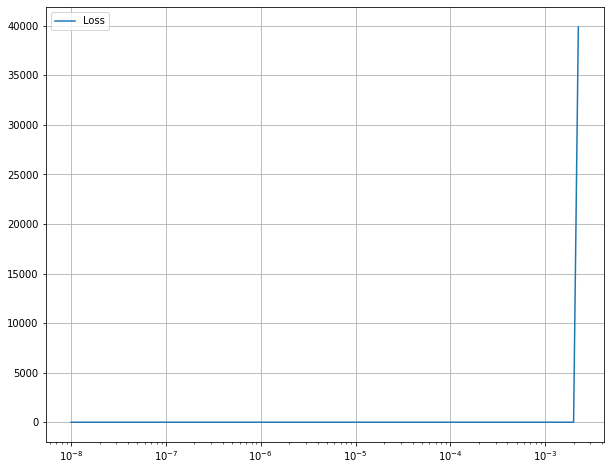

In [ ]:
lrs= 1e-8*(10**(np.arange(125)/20))
plt.semilogx(lrs, history.history["loss"], label='Loss')
plt.legend(loc='best')
plt.grid(True)

**Model Training**

In [ ]:
tf.keras.backend.clear_session()

#creating model
model= tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, activation='relu', dropout=0.25, recurrent_dropout=0.2, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.3, return_sequences=True)), 
                                   tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.1), 
                                   tf.keras.layers.Dropout(0.15),  
                                   tf.keras.layers.Dense(1)
                                   ])

adam= tf.keras.optimizers.Adam(lr=lr)
model.compile(optimizer= adam, loss= 'mse')
#Smodel.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 48)          4992      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 24)          5856      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 12,637
Trainable params: 12,637
Non-trainable params: 0
____________________________________________________

In [ ]:
history= model.fit(x,y, epochs= 300, verbose=0)

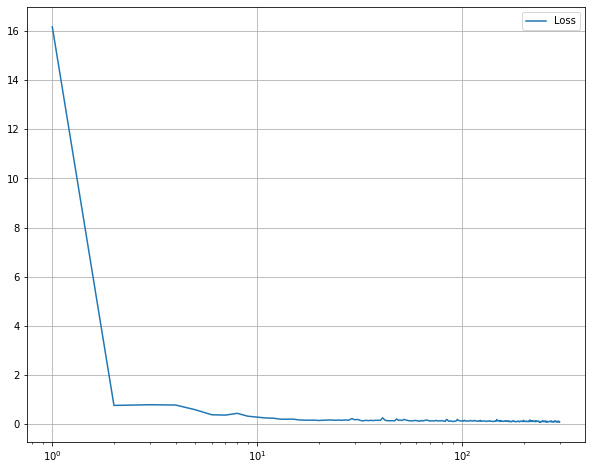

In [ ]:
epochs= range(1,301)
plt.semilogx(epochs, history.history["loss"], label='Loss')
plt.legend(loc='best')
plt.grid(True)

(417, 12, 1)
(417, 1)


[]

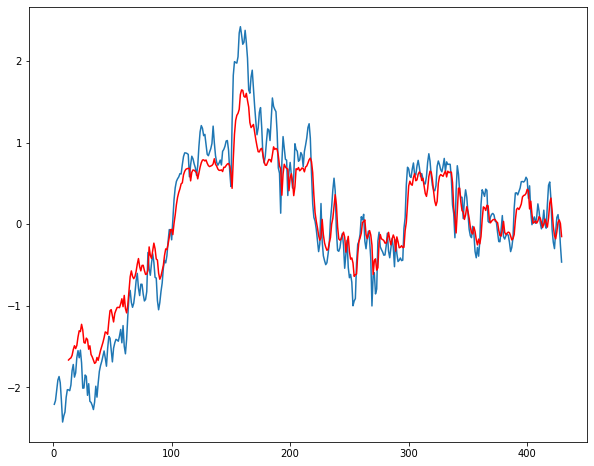

In [ ]:
numbers=range(1, 430)
num= range(13,430)
plt.figure()
print(x.shape)
y_pred= model.predict(x)
print(y_pred.shape)
plt.plot(numbers,array)
plt.plot(num,y_pred,'r')
plt.plot()

**Test Phase**

[]

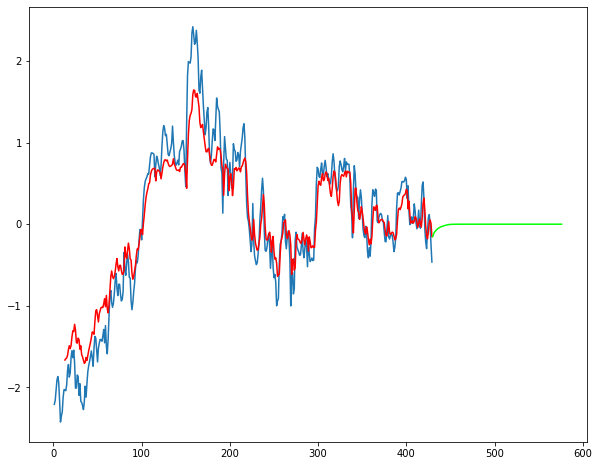

In [ ]:
numbers=range(1, 430)
num= range(13,430)
pred= range(430,577)
plot_pred=[]
real_val=[]
plt.figure()
y_pred= model.predict(x)
plt.plot(numbers,array)
plt.plot(num,y_pred,'r')
x_new= array[416: len(array)-1]
for i in range(147):
  x_new= x_new.reshape(1,12,1)
  y_new= model.predict(x_new)
  x_new= x_new[0][1:]
  x_new= np.append(x_new, y_new)
  y_new= y_new.reshape(1,)
  real= y_new*array_std+array_mean
  plot_pred.append(y_new)
  real_val.append(real)

plt.plot(pred, plot_pred, color='#00ff00')
plt.plot()

In [ ]:
pred_array = np.array(real_val)
pred_array.shape

(147, 1)

In [ ]:
answer['Close-Stock-4'] = pred_array.flatten()
answer

,Date,Close-Stock-1,Close-Stock-2,Close-Stock-3,Close-Stock-4
0,2011-08-04,574.658691,211.067871,2977.268799,1031.367065
1,2011-08-05,574.593018,213.217712,2910.111572,1034.629761
2,2011-08-06,574.630981,216.291580,2871.305176,1036.482056
3,2011-08-07,574.512451,220.956924,2855.853760,1037.780151
4,2011-08-08,574.598389,227.928192,2844.355469,1038.914062
...,...,...,...,...,...
142,2011-12-24,574.191040,301.884796,2788.281006,1045.620361
143,2011-12-25,574.190918,301.884796,2788.281006,1045.620361
144,2011-12-26,574.191040,301.884796,2788.281006,1045.620361
145,2011-12-27,574.190918,301.884796,2788.281006,1045.620361


# Stock 5

In [ ]:
df5= result.loc[:,['Date','Close-Stock-5']]
df5.head()

,Date,Close-Stock-5
0,2010-06-01,1181.70
1,2010-06-02,1201.15
2,2010-06-03,1242.30
3,2010-06-04,1245.45
4,2010-06-07,1214.80


In [ ]:
idx = pd.date_range(df5.Date.min(), df5.Date.max())
df5.set_index('Date', inplace=True)

**Cubic Spline interpolation**

In [ ]:
df5 = df5.reindex(idx)
df5.index.name = 'Date'
# df1= df1.replace({0:np.NaN})
df5= df5.interpolate(method='spline', order=3, s=0.)
df5 = df5.round(2)
df5

,Close-Stock-5
Date,
2010-06-01,1181.70
2010-06-02,1201.15
2010-06-03,1242.30
2010-06-04,1245.45
2010-06-05,1231.88
...,...
2011-07-30,1358.39
2011-07-31,1359.55
2011-08-01,1353.00


In [ ]:
array = df5.to_numpy().reshape(-1,1)
array.shape

(429, 1)

In [ ]:
#taking mean and standered deviation
array_mean = array.mean()
array_std = array.std()
#normalizing the data
array = (array-array_mean)/array_std

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [ ]:
univariate_past_history = 12
univariate_future_target = 0

x, y = univariate_data(array, 0, None, univariate_past_history, univariate_future_target)

In [ ]:
print('X Shape:',x.shape)
print('Y Shape:',y.shape)

X Shape: (417, 12, 1)
Y Shape: (417, 1)


**Learning Rate Scheduling**

In [ ]:
tf.keras.backend.clear_session()

#creating model
model= tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, activation='relu', dropout=0.25, recurrent_dropout=0.2, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.3, return_sequences=True)), 
                                   tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.1), 
                                   tf.keras.layers.Dropout(0.15),  
                                   tf.keras.layers.Dense(1)
                                   ])
lr_schedular= tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-6*10**(x/20))

adam= tf.keras.optimizers.Adam(lr=1e-6)
model.compile(optimizer= adam, loss= 'mse')
#Smodel.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 48)          4992      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 24)          5856      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 12,637
Trainable params: 12,637
Non-trainable params: 0
____________________________________________________

In [ ]:
history= model.fit(x, y, epochs= 125, callbacks= [lr_schedular], verbose=0)

In [ ]:
loss= min(history.history['loss'])
losses= history.history['loss']
index=losses.index(loss)
lrs= history.history['lr']
count=0
for i in lrs:
  if count==index:
    lr=i
    break
  count+=1
print(lr)
print(loss)

0.0891251
0.1275883913040161


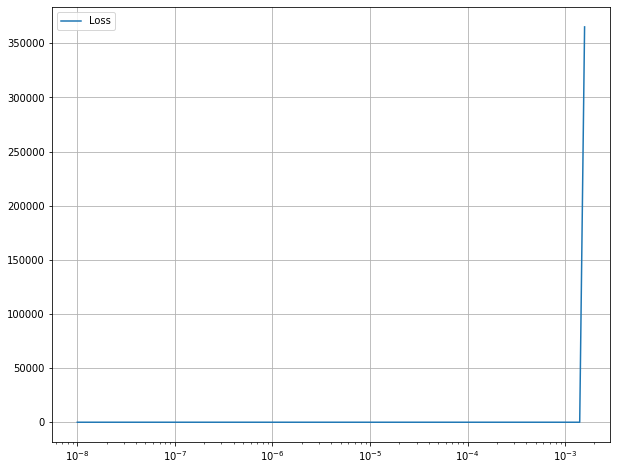

In [ ]:
lrs= 1e-8*(10**(np.arange(125)/20))
plt.semilogx(lrs, history.history["loss"], label='Loss')
plt.legend(loc='best')
plt.grid(True)

**Model Training**

In [ ]:
tf.keras.backend.clear_session()

#creating model
model= tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, activation='relu', dropout=0.25, recurrent_dropout=0.2, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.3, return_sequences=True)), 
                                   tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.1), 
                                   tf.keras.layers.Dropout(0.15),  
                                   tf.keras.layers.Dense(1)
                                   ])

adam= tf.keras.optimizers.Adam(lr=lr)
model.compile(optimizer= adam, loss= 'mse')
#Smodel.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 48)          4992      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 24)          5856      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 12,637
Trainable params: 12,637
Non-trainable params: 0
____________________________________________________

In [ ]:
history= model.fit(x,y, epochs= 300, verbose=0)

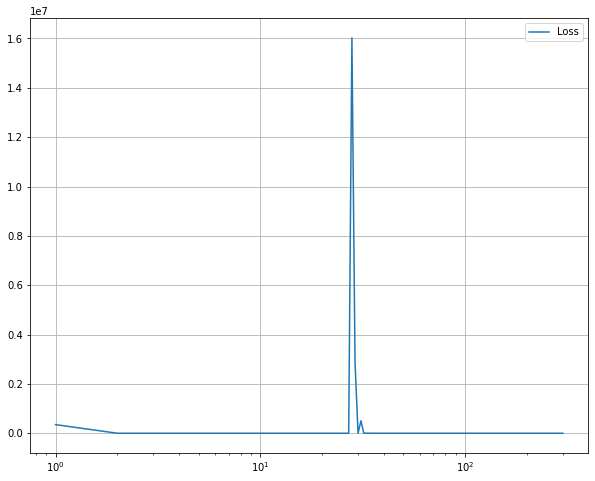

In [ ]:
epochs= range(1,301)
plt.semilogx(epochs, history.history["loss"], label='Loss')
plt.legend(loc='best')
plt.grid(True)

(417, 12, 1)
(417, 1)


[]

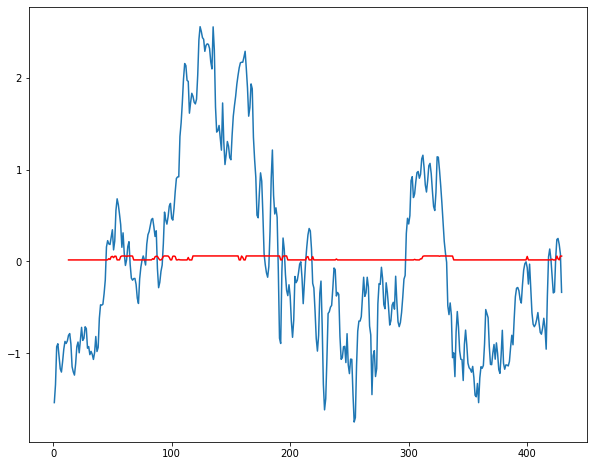

In [ ]:
numbers=range(1, 430)
num= range(13,430)
plt.figure()
print(x.shape)
y_pred= model.predict(x)
print(y_pred.shape)
plt.plot(numbers,array)
plt.plot(num,y_pred,'r')
plt.plot()

**Test Phase**

[]

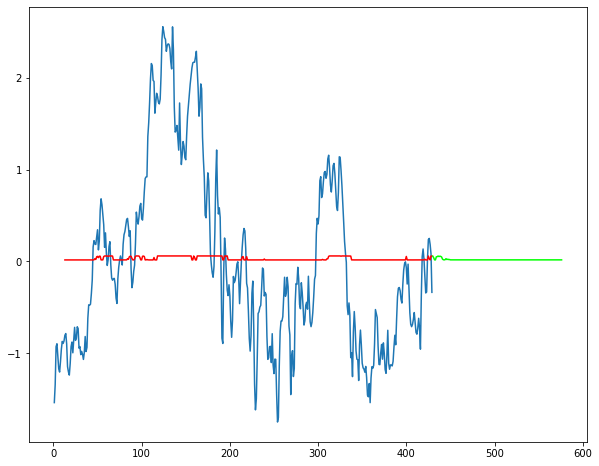

In [ ]:
numbers=range(1, 430)
num= range(13,430)
pred= range(430,577)
plot_pred=[]
real_val=[]
plt.figure()
y_pred= model.predict(x)
plt.plot(numbers,array)
plt.plot(num,y_pred,'r')
x_new= array[416: len(array)-1]
for i in range(147):
  x_new= x_new.reshape(1,12,1)
  y_new= model.predict(x_new)
  x_new= x_new[0][1:]
  x_new= np.append(x_new, y_new)
  y_new= y_new.reshape(1,)
  real= y_new*array_std+array_mean
  plot_pred.append(y_new)
  real_val.append(real)

plt.plot(pred, plot_pred, color='#00ff00')
plt.plot()

In [ ]:
pred_array = np.array(real_val)
pred_array.shape

(147, 1)

In [ ]:
answer['Close-Stock-5'] = pred_array.flatten()
answer

,Date,Close-Stock-1,Close-Stock-2,Close-Stock-3,Close-Stock-4,Close-Stock-5
0,2011-08-04,574.658691,211.067871,2977.268799,1031.367065,1340.386963
1,2011-08-05,574.593018,213.217712,2910.111572,1034.629761,1338.660400
2,2011-08-06,574.630981,216.291580,2871.305176,1036.482056,1336.343994
3,2011-08-07,574.512451,220.956924,2855.853760,1037.780151,1336.308350
4,2011-08-08,574.598389,227.928192,2844.355469,1038.914062,1339.605347
...,...,...,...,...,...,...
142,2011-12-24,574.191040,301.884796,2788.281006,1045.620361,1336.331299
143,2011-12-25,574.190918,301.884796,2788.281006,1045.620361,1336.331299
144,2011-12-26,574.191040,301.884796,2788.281006,1045.620361,1336.331299
145,2011-12-27,574.190918,301.884796,2788.281006,1045.620361,1336.331299


# Data Cleaning

In [ ]:
cond = ~answer['Date'].isin(test['Date'])
final_answer = answer.drop(answer[cond].index)
final_answer

,Date,Close-Stock-1,Close-Stock-2,Close-Stock-3,Close-Stock-4,Close-Stock-5
0,2011-08-04,574.658691,211.067871,2977.268799,1031.367065,1340.386963
1,2011-08-05,574.593018,213.217712,2910.111572,1034.629761,1338.660400
4,2011-08-08,574.598389,227.928192,2844.355469,1038.914062,1339.605347
5,2011-08-09,574.439697,239.229218,2835.258545,1039.861084,1339.801636
6,2011-08-10,574.477173,254.946899,2824.857910,1040.657593,1340.474365
...,...,...,...,...,...,...
140,2011-12-22,574.190918,301.884796,2788.281006,1045.620361,1336.331299
141,2011-12-23,574.191040,301.884796,2788.281006,1045.620361,1336.331299
144,2011-12-26,574.191040,301.884796,2788.281006,1045.620361,1336.331299
145,2011-12-27,574.190918,301.884796,2788.281006,1045.620361,1336.331299


In [ ]:
final_answer.set_index('Date', inplace=True)
final_answer.to_csv('output.csv')
final_answer

,Close-Stock-1,Close-Stock-2,Close-Stock-3,Close-Stock-4,Close-Stock-5
Date,,,,,
2011-08-04,574.658691,211.067871,2977.268799,1031.367065,1340.386963
2011-08-05,574.593018,213.217712,2910.111572,1034.629761,1338.660400
2011-08-08,574.598389,227.928192,2844.355469,1038.914062,1339.605347
2011-08-09,574.439697,239.229218,2835.258545,1039.861084,1339.801636
2011-08-10,574.477173,254.946899,2824.857910,1040.657593,1340.474365
...,...,...,...,...,...
2011-12-22,574.190918,301.884796,2788.281006,1045.620361,1336.331299
2011-12-23,574.191040,301.884796,2788.281006,1045.620361,1336.331299
2011-12-26,574.191040,301.884796,2788.281006,1045.620361,1336.331299
